In [11]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [12]:
import torch

#torch.cuda.is_available()
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-32GB'

# EDA

In [13]:
combination = [(m, g, a) for m in ['m', 'i', 'n'] for g in ['male', 'female'] for a in [0, 1, 2]]

In [14]:
combination

[('m', 'male', 0),
 ('m', 'male', 1),
 ('m', 'male', 2),
 ('m', 'female', 0),
 ('m', 'female', 1),
 ('m', 'female', 2),
 ('i', 'male', 0),
 ('i', 'male', 1),
 ('i', 'male', 2),
 ('i', 'female', 0),
 ('i', 'female', 1),
 ('i', 'female', 2),
 ('n', 'male', 0),
 ('n', 'male', 1),
 ('n', 'male', 2),
 ('n', 'female', 0),
 ('n', 'female', 1),
 ('n', 'female', 2)]

In [42]:
img_name = '/opt/ml/input/data/train/images/000523_female_Asian_51/mask4.jpg'

mask = img_name.split('/')[-1][:1]
features = img_name.split('/')[-2].split('_')
gender = features[1]
age = int(features[3]) // 30

In [43]:
gender, _, age = img_name.split('/')[-2].split('_')[1:]

In [46]:
for i, (m, g, a) in enumerate(combination):
    if mask == m and gender == g and age == a:
        target = i

In [47]:
train_dir = '/opt/ml/input/data/train'

In [48]:
table = pd.read_csv('/opt/ml/input/data/train/train.csv')
table.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [49]:
table.iloc[1, 4]

'000002_female_Asian_52'

In [50]:
table_origin = table.copy()

In [51]:
table.describe()

,age
count,2700.000000
mean,37.708148
std,16.985904
min,18.000000
25%,20.000000
50%,36.000000
75%,55.000000
max,60.000000


In [52]:
dic_gender = {'male': 0, 'female': 1}

def one_hot_encoding(data, dic):
    output = []
    for d in data:
        output.append(dic[d])
    return output

In [53]:
one_hot_encoding(table.gender, dic_gender)[:6]

[1, 1, 0, 1, 1, 1]

In [54]:
table.gender = one_hot_encoding(table.gender, dic_gender)

In [55]:
table.race.value_counts()

Asian    2700
Name: race, dtype: int64

In [56]:
del table['race']

In [57]:
del table['path']

In [58]:
table_origin.gender.value_counts()

female    1658
male      1042
Name: gender, dtype: int64

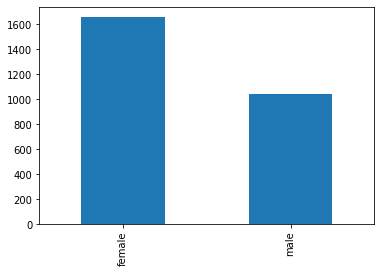

In [59]:
table_origin.gender.value_counts().plot.bar()

In [60]:
table.age.describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

In [61]:
table.age[table.age < 30] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
table.age[58 <= table.age] = 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
table.age[30 <= table.age] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
table.age.value_counts()

0    1281
1     983
2     436
Name: age, dtype: int64

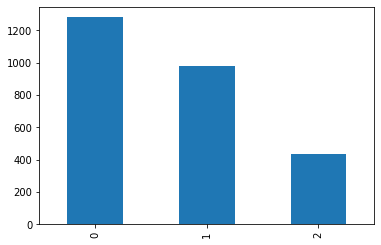

In [65]:
table.age.value_counts().plot.bar()

# Data loader

In [39]:
len(os.listdir(train_dir + '/images'))

5400

In [40]:
file_name = []
ids = []
for name_underscore in os.listdir(train_dir + '/images'):
    if not name_underscore[:2] == '._':
        file_name.append(name_underscore)
        ids.append(name_underscore.split('_')[0])

In [ ]:
set(name) == set(table.id.values)

In [ ]:
data = []
for person in file_name:
    images = [train_dir + '/images/' + person + '/' + image for image in os.listdir(train_dir + '/images/' + person) if not image[:1] == '.']
    for image in images:
        data.append(image)

In [ ]:
len(data) / 2700

In [ ]:
len(ids)

In [ ]:
ids = []
genders = []
ages = []
masks = []

for d in data:
    mask = d.split('/')[-1][:1]
    features = d.split('/')[-2].split('_')
    ids.append(features[0])
    genders.append(features[1])
    ages.append(int(features[3]) // 30)
    masks.append(mask)

In [ ]:
df = pd.DataFrame({'id': ids, 'gender': genders, 'age': ages, 'Mask': masks, 'target': None, 'img': data})

In [ ]:
combination = [(m, g, a) for m in ['m', 'i', 'n'] for g in ['male', 'female'] for a in [0, 1, 2]]

In [ ]:
for i, (m, g, a) in enumerate(combination):
    df.target[(df.Mask == m) & (df.gender == g) & (df.age == a)] = i

In [ ]:
df.target.value_counts()

In [ ]:
df.target.value_counts().plot.bar()

In [ ]:
df.gender = one_hot_encoding(df.gender, dic_gender)

In [ ]:
df.gender.map(dic_gender).value_counts()

In [ ]:
fig = plt.figure(figsize=(15,25))
idx = 0

for i in range(20):
    rand = random.randint(0, len(df))
    img = Image.open(df.img[rand])
    idx += 1
    ax = plt.subplot(5, 4, idx)
    ax.set_title(df.Mask[rand] + '/' + df.gender[rand] + '/' + str(df.age[rand]))
    plt.imshow(img)

In [ ]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class cfg:
    data_dir = '/opt/ml/input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [ ]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

In [ ]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [ ]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [ ]:
img_info = get_img_stats(cfg.img_dir, df.path.values)

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

In [ ]:
plt.figure(figsize=(6, 4.5)) 
ax = sns.countplot(x = 'gender', data = df, palette=["#55967e", "#263959"])

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('Sex Ratio',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()

In [ ]:
sns.displot(df, x="age", hue="gender", stat="density")

In [ ]:
# 마스크의 유무에 따른 이미지 픽셀값의 분포

In [ ]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

In [ ]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)

In [ ]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])

In [ ]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - Normal', fontsize=15)

In [ ]:
def plot_raw_images(img_dir, img_id):
    ext = get_ext(img_dir, img_id)
    img = np.array(Image.open(os.path.join(img_dir, img_id, 'normal' + ext)))
    
    plt.figure(figsize=(6,6))
    plt.imshow(img)

In [ ]:
plot_raw_images(cfg.img_dir, img_id)

In [ ]:
def plot_mask_images(img_dir, img_id):
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))
    for i in range(n_rows*n_cols):
        axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
        axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}', color='r')
    plt.tight_layout()

In [ ]:
plot_mask_images(cfg.img_dir, img_id)

In [ ]:
os.getcwd()

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
imgs = []
for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
    imgs.append(img)
imgs = np.array(imgs)

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])

In [ ]:
for img in imgs:
    face_bbox = face_cascade.detectMultiScale(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 1.1, 4)
    for (x, y, w, h) in face_bbox:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 4)

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])

In [ ]:
# PCA

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
n_imgs = 100

imgs = []
for img_id in df.path.values[:n_imgs]:
    for class_id in num2class:
        img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w))

In [ ]:
n_components = 30

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

In [ ]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

In [ ]:
pca_df.head()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='0', y='1',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k: v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"], 
    ys=pca_df["1"], 
    zs=pca_df["2"], 
    c=pca_df['class_id'].map(lambda x: simplified_class2num[x]), 
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [ ]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

In [ ]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)